# Analysis of multiumbrella coexsitence simulations

In [3]:
import numpy as np
import matplotlib.pylab as plt
import glob, pickle
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import scipy.interpolate
%config InlineBackend.figure_format = 'retina'


### Load data

In [4]:
def read_colvar_dict(fn):
    
    # Determine fields
    with open(fn,'r') as fp:
        top = fp.readline()
        fields= top.split()[2:]
    
    # Load data columns
    data=np.genfromtxt(fn)
    
    # Create dictionary
    ret = dict()
    for i, field in enumerate(fields):
        ret[field]=data[:,i]
    ret['time_ns']=data[:,0]/1E3    
    return ret

In [13]:
sims=dict()

for fold in glob.glob('COEX_*/*K/'):
    print(fold)
    sims[fold] = dict()
    try:
        sims[fold]['COLVAR'] = [read_colvar_dict(fold+'COLVAR')]#.format(i)) for i in range(nmpi)]
        sims[fold]['DELTAFS'] = np.genfromtxt(fold+'DELTAFS')
        sims[fold]['T'] = float(fold.split('/')[-2].strip('K'))
        sims[fold]['P'] = float(fold.split('/')[-3].replace('COEX_','').strip('bar'))
    except:
        sims.pop(fold)
        pass
with open('coex.pickle', 'wb') as handle:
    pickle.dump(sims, handle, protocol=pickle.HIGHEST_PROTOCOL)

COEX_1000.0bar/270.0K/
COEX_1000.0bar/265.0K/
COEX_1000.0bar/260.0K/
COEX_1000.0bar/280.0K/
COEX_1000.0bar/275.0K/
COEX_2500.0bar/255.0K/
COEX_2500.0bar/240.0K/
COEX_2500.0bar/235.0K/
COEX_2500.0bar/245.0K/
COEX_2500.0bar/250.0K/
COEX_0.0bar/270.0K/
COEX_0.0bar/265.0K/
COEX_0.0bar/285.0K/
COEX_0.0bar/280.0K/
COEX_0.0bar/275.0K/
COEX_2000.0bar/255.0K/
COEX_2000.0bar/245.0K/
COEX_2000.0bar/250.0K/
COEX_2000.0bar/260.0K/
COEX_2000.0bar/265.0K/
COEX_3000.0bar/240.0K/
COEX_3000.0bar/230.0K/
COEX_3000.0bar/225.0K/
COEX_3000.0bar/245.0K/
COEX_3000.0bar/235.0K/


In [6]:
with open('coex.pickle', 'rb') as handle:
    sims = pickle.load(handle)

In [29]:
#Specific settings for each ice-liquid inteface
single_pressure='7000.0bar'
single_temp='270.0K'

nmpi=1

dp=0.05
dpl=0.05
dph=dp
dh=5
n_temps=5
n_pressures=5
num_ice_range=[i for i in range(ns,nf+1)]
NIGNORE_STANDARD=1500

### Estimation of chemical potential from collective variables and bias

In [30]:
def linear_fn(x, a, b):
    return a*x + b

## Analysis for all pressures

### Time evolution of all collective variables

In [31]:
for key in sims.keys():
    sims[key]['NIGNORE']=NIGNORE_STANDARD
# First batch
# # remove extra frames for specific simulations
# sims['COEX_1.0bar/275K/']['NIGNORE']=5000
# sims['COEX_1001.0bar/265K/']['NIGNORE']=7500
#sims['COEX_2500.0bar/250K/']['NIGNORE']=-1
#sims['COEX_2500.0bar/255K/']['NIGNORE']=-1
# sims['COEX_201.0bar/255K/']['NIGNORE']=8000
#sims['COEX_7000.0bar/245K/']['NIGNORE']=-1
#sims['COEX_7000.0bar/255K/']['NIGNORE']=-1
#sims['COEX_7000.0bar/250K/']['NIGNORE']=-1
#sims['COEX_6000.0bar/245K/']['NIGNORE']=-1
#sims['COEX_6000.0bar/255K/']['NIGNORE']=-1
#sims['COEX_6000.0bar/250K/']['NIGNORE']=-1

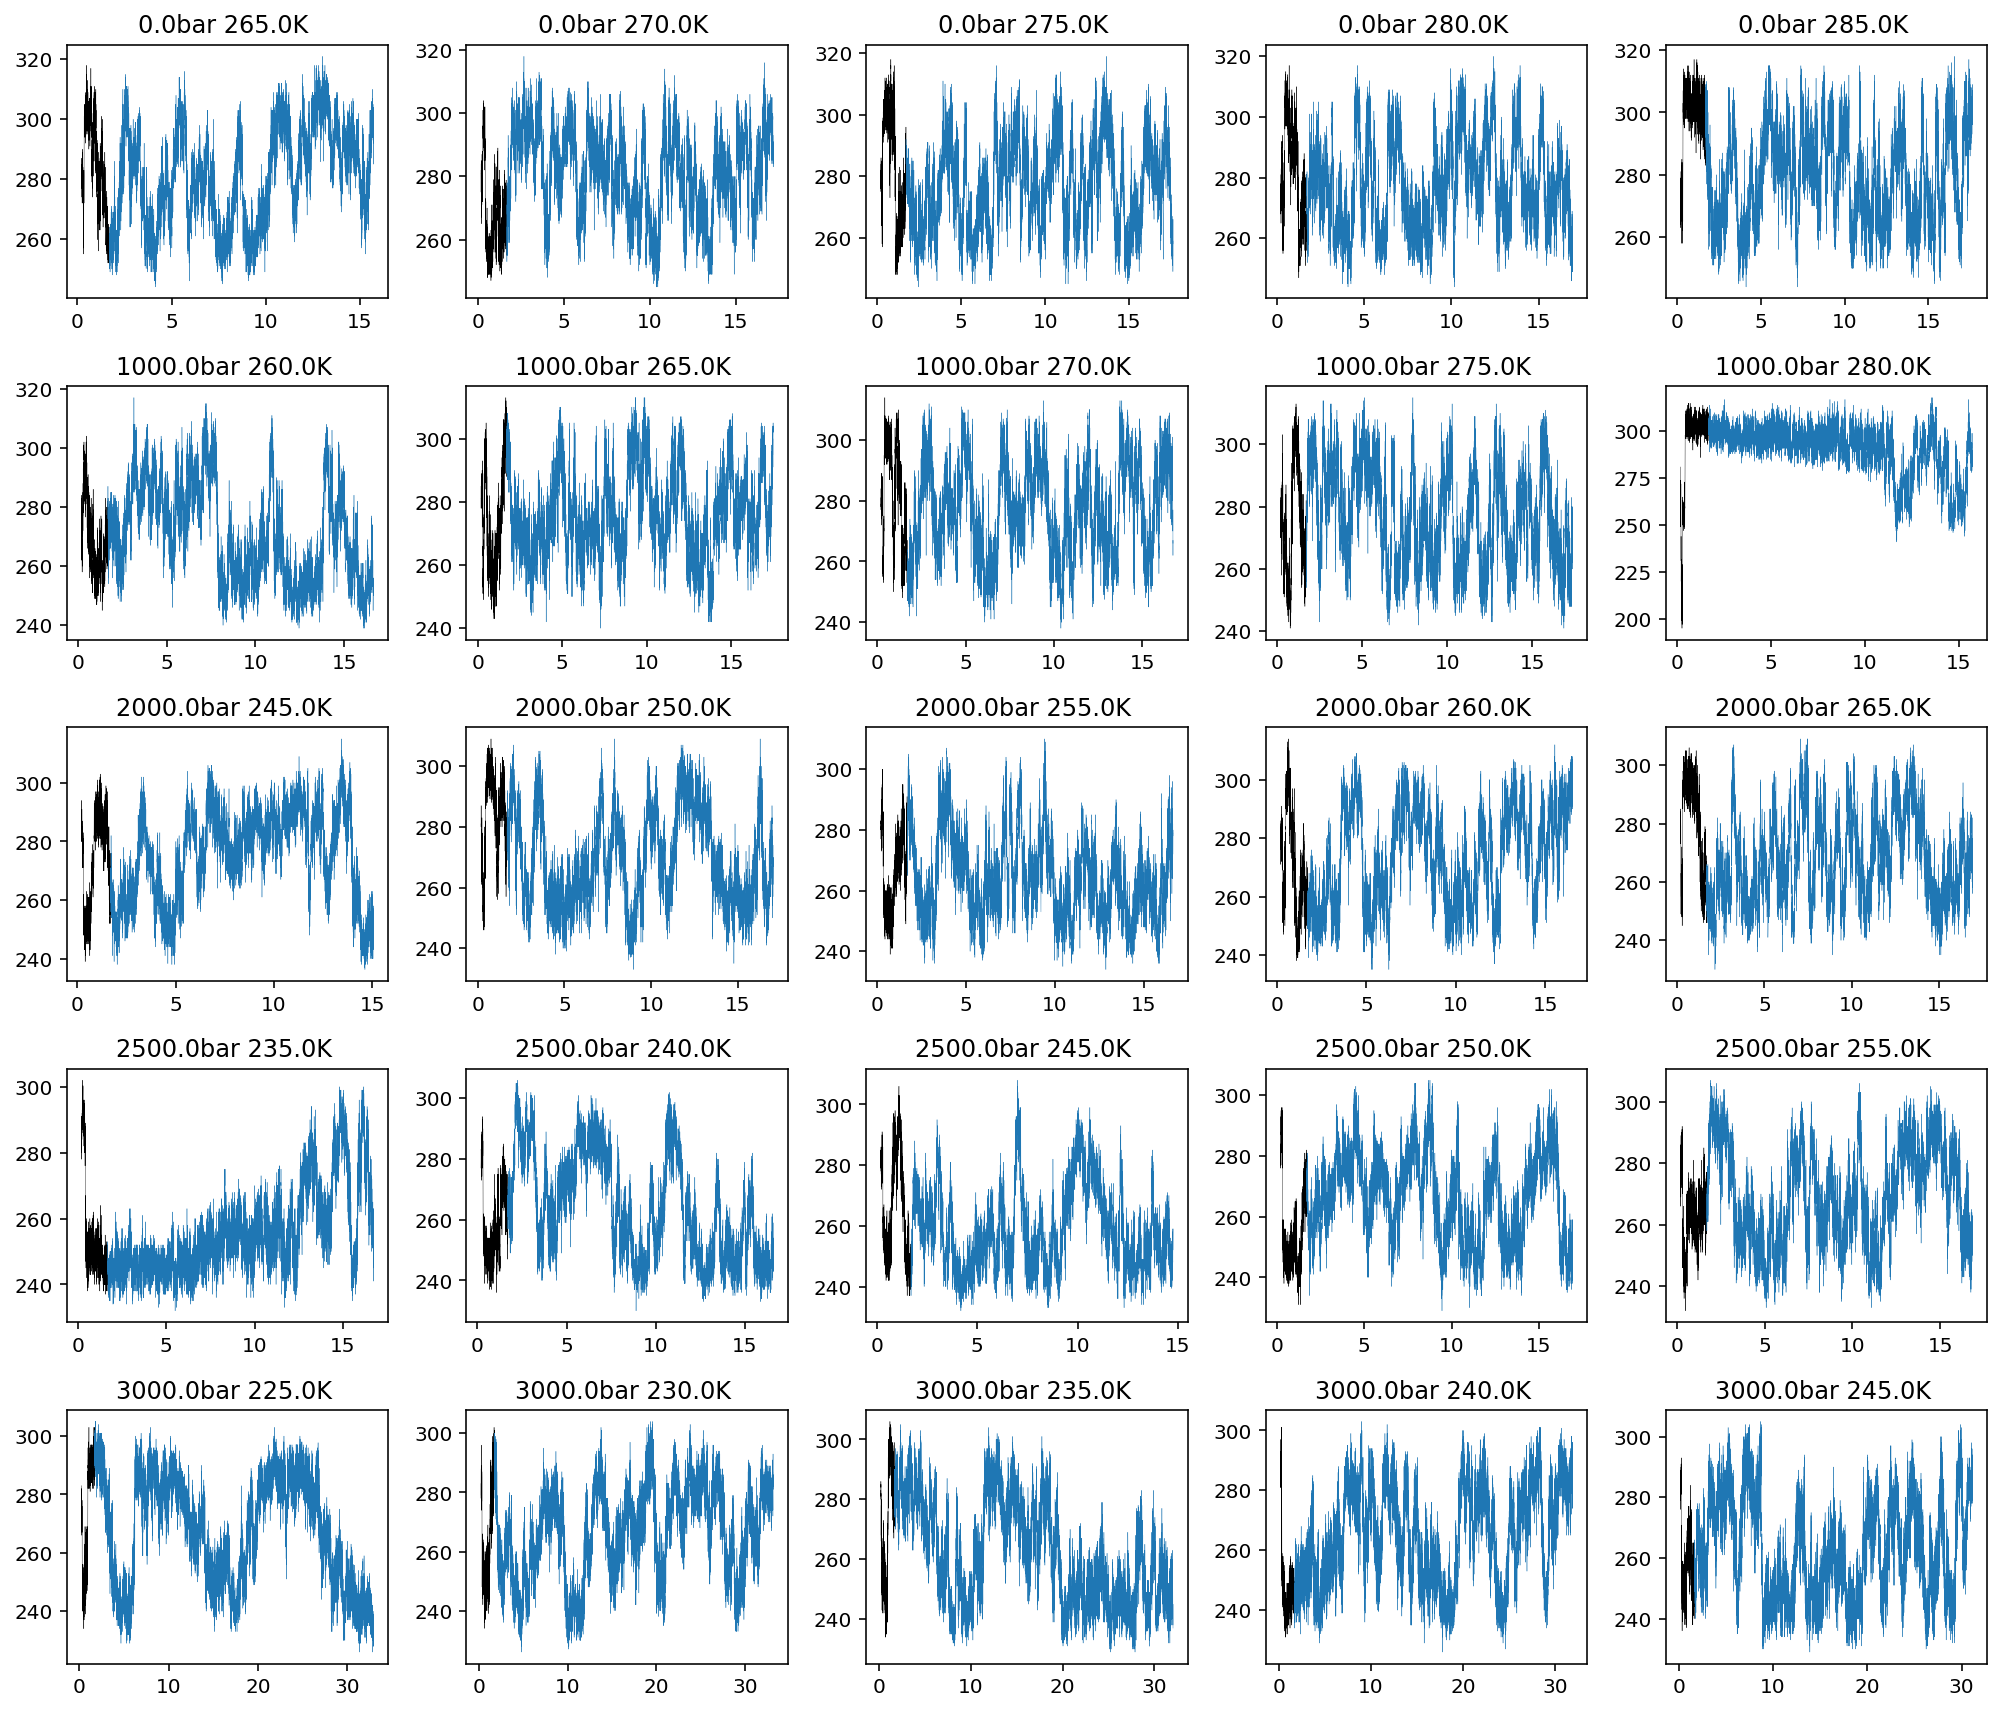

In [32]:
# Plot time evolution of collective variables
fig, axs = plt.subplots(n_pressures,n_temps,figsize=(14,12))
axs=axs.flatten()
i=0
for  key in sorted(sims.keys()):
    if 'COLVAR' in list(sims[key].keys()):
     
        time0=0.2
        for j in range(nmpi):
            colvar=sims[key]['COLVAR'][j]
            NIGNORE=sims[key]['NIGNORE']

  
            axs[i].title.set_text(key.replace('COEX_','').replace('/', ' '))
            if sims[key]['NIGNORE']>0:
                # Part not used for fit
                axs[i].plot(time0+colvar['time_ns'][:NIGNORE],colvar['refcv2.morethan'][:NIGNORE],'k',lw=0.2)
                # Part used for fit
                axs[i].plot(time0+colvar['time_ns'][NIGNORE:],colvar['refcv2.morethan'][NIGNORE:],lw=0.2)
            else:
                # Whole simulation not used for fit
                axs[i].plot(time0+colvar['time_ns'],colvar['refcv2.morethan'],'k',lw=0.2)
            time0+=colvar['time_ns'][-1]
        i+=1
        
plt.tight_layout()


### Determine range for strict collective variable

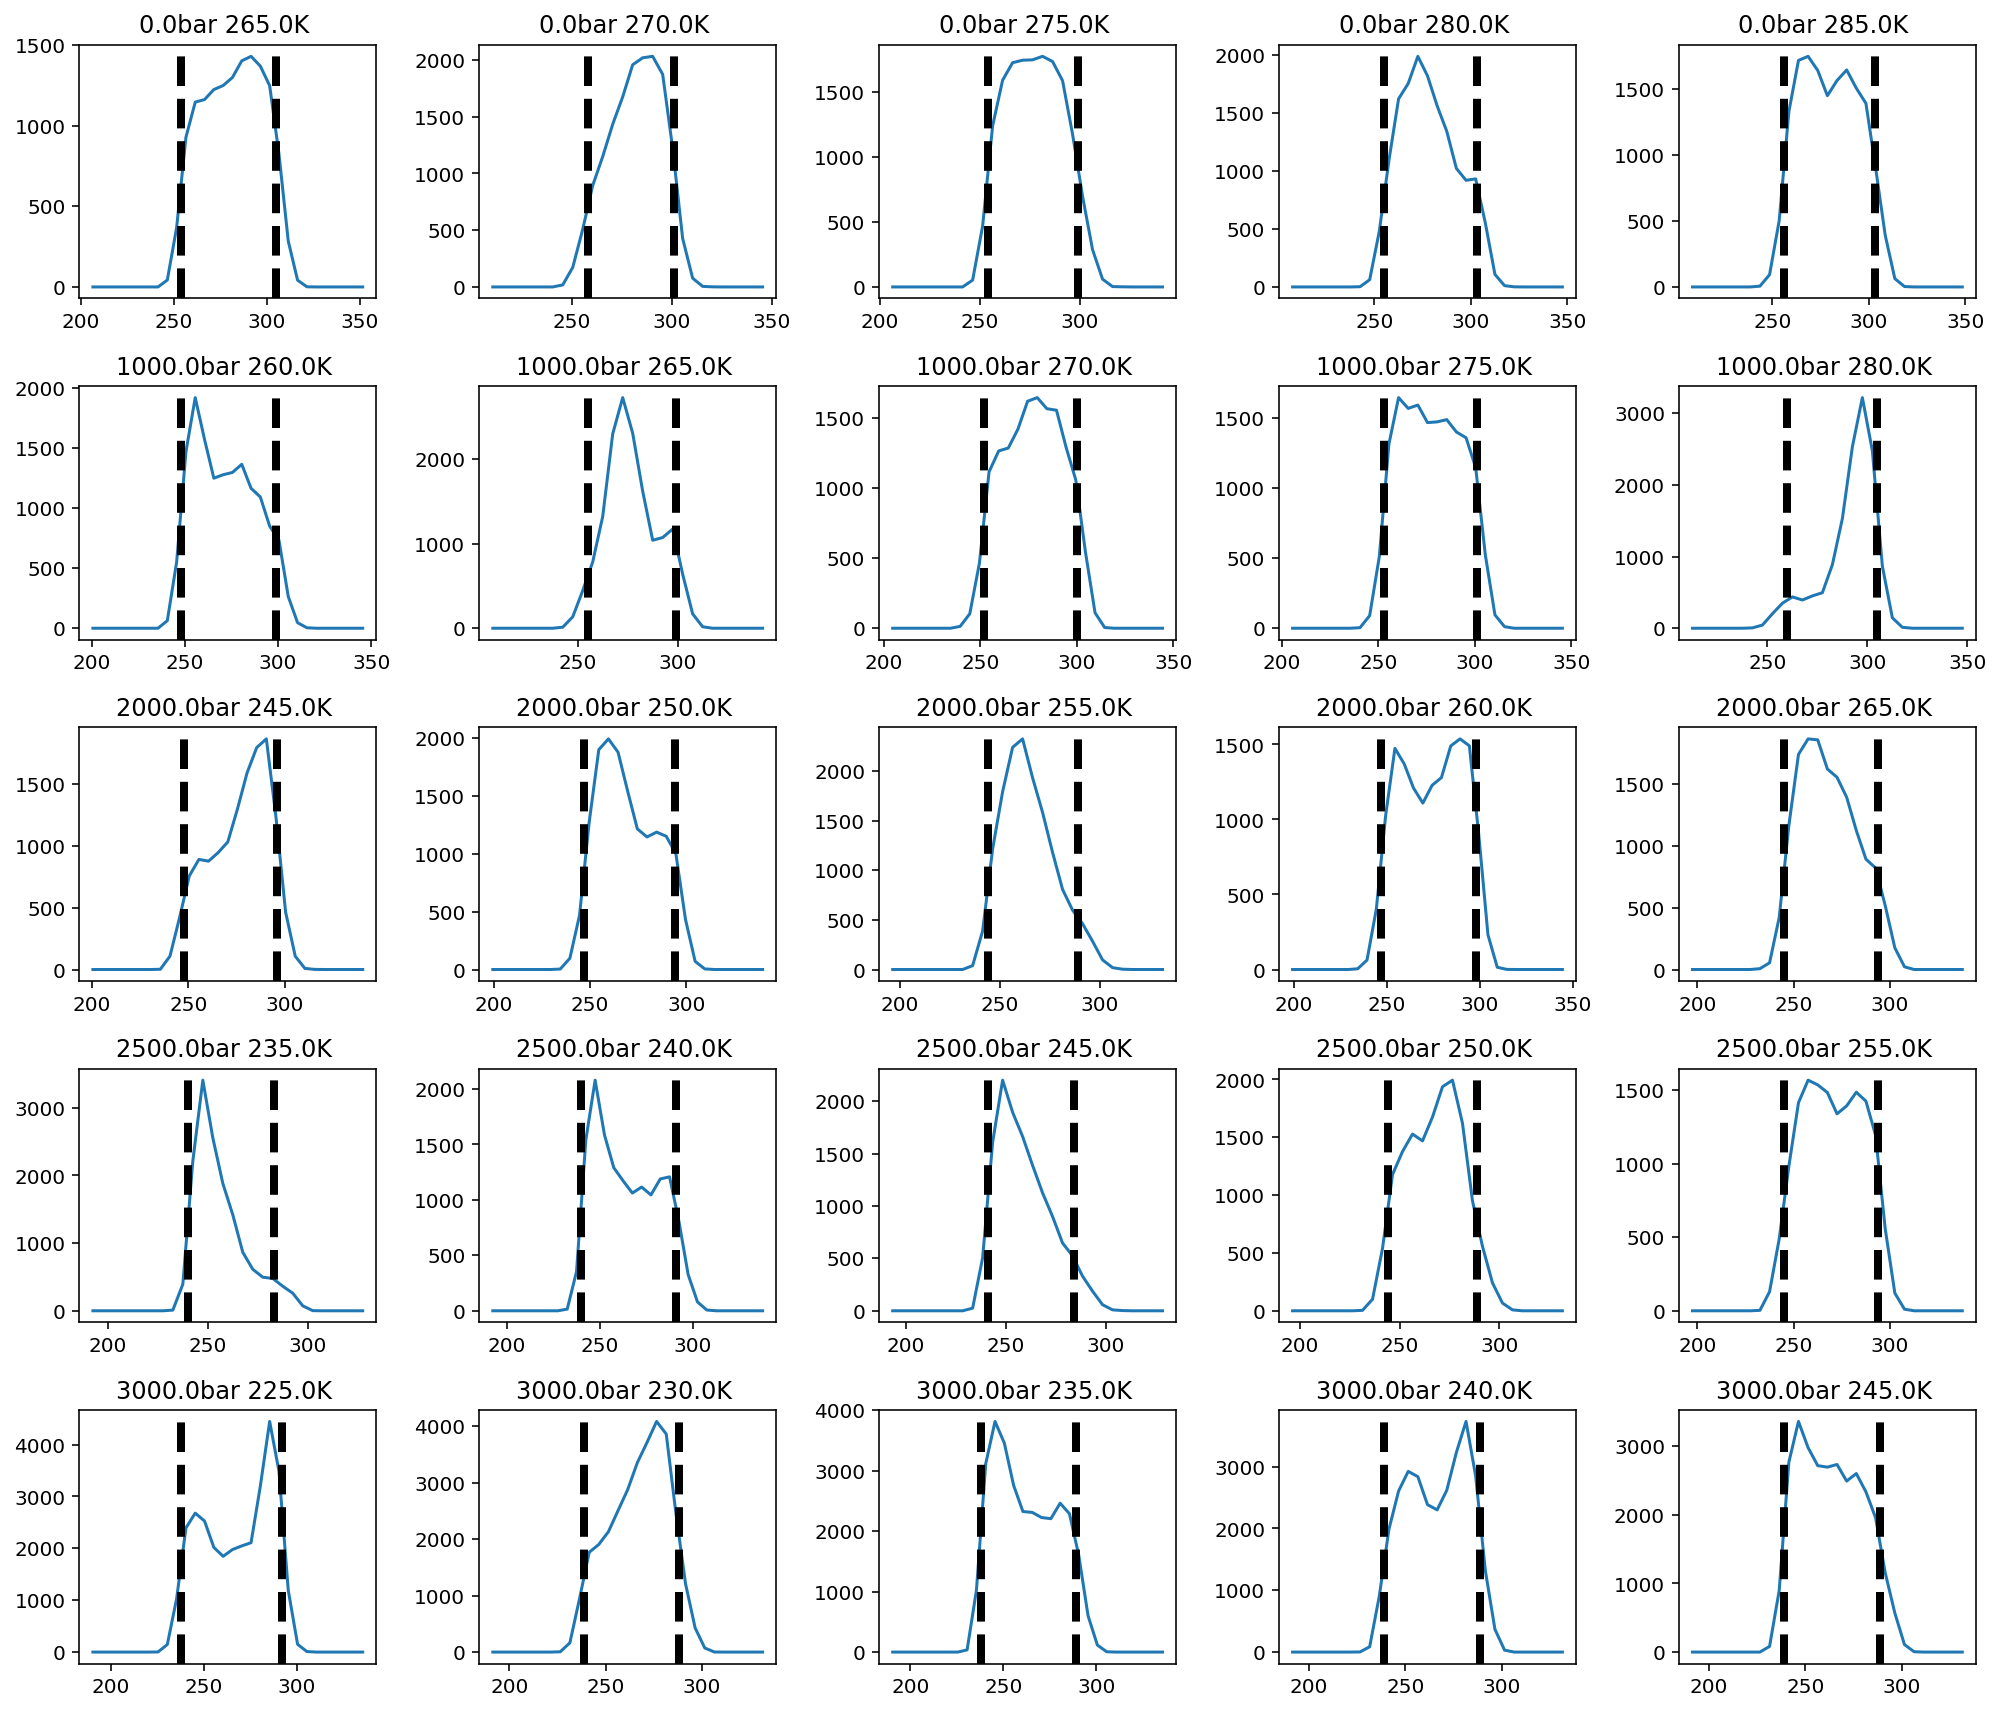

In [33]:
fig, axs = plt.subplots(n_pressures,n_temps,figsize=(14,12))
axs=axs.flatten()
for i, key in enumerate(sorted(sims.keys())):  
    NIGNORE=sims[key]['NIGNORE']

    number_of_ice  = np.hstack(tuple([sims[key]['COLVAR'][mpi]['refcv2.morethan'][NIGNORE:] for mpi in range(nmpi)]))
    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-50,nf+50)]
    sims[key]['num_ice_bins']=num_ice_bins
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh])
    #histo, bin_edges = np.histogram(number_of_ice)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])
    if NIGNORE<0:
        continue
    axs[i].plot(n_ice_mid,histo)
    axs[i].axvline(x=ns,linewidth=4, color='k',ls='--')
    axs[i].axvline(x=nf,linewidth=4, color='k',ls='--')
    axs[i].title.set_text(key.replace('COEX_','').replace('/', ' '))
plt.tight_layout()

In [37]:
colors = plt.cm.jet(np.linspace(0,0.6,n_temps))

sims_result = dict()
for i, key in enumerate(sorted(sims.keys())):  
    # Load data
    sim=sims[key]
    NIGNORE=sim['NIGNORE']
    NBINS=len(sim['DELTAFS'][0,2:])//4#//3
    colvar =sim['COLVAR'] 
    if NIGNORE<0:
        continue
  
    #try:
    bias_potential = np.hstack(tuple([colvar[mpi]['opes.bias'][NIGNORE:] for mpi in range(nmpi)]))
    number_of_ice  = np.hstack(tuple([colvar[mpi]['refcv2.morethan'][NIGNORE:] for mpi in range(nmpi)]))

    # Create reweighted histogram
    beta = 1./(0.00831441001626*sim['T']) # 1/(kJ/mol)
    logweights = beta*bias_potential
    logweights -= np.amax(logweights)
    bins=sim['num_ice_bins'][::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)
    
    # Estimate error of bin
    fes_error = (1/beta)*histo_error/histo

    # Exclude ends
    fes=fes#[IGNORE_BINS_START:-IGNORE_BINS_END]
    bin_centers=bin_centers#[IGNORE_BINS_START:-IGNORE_BINS_END]
    fes_error=fes_error#[IGNORE_BINS_START:-IGNORE_BINS_END]

    # Fit linear curve
    try:
        popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error)
    except:
        continue
    sims_result[key]=dict()
    sims_result[key]['n_water']=bin_centers
    sims_result[key]['fes']=fes
    sims_result[key]['fes_err']=fes

    sims_result[key]['fes_linear']=linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    sims_result[key]['chem_pot'] = [popt[0],perr]

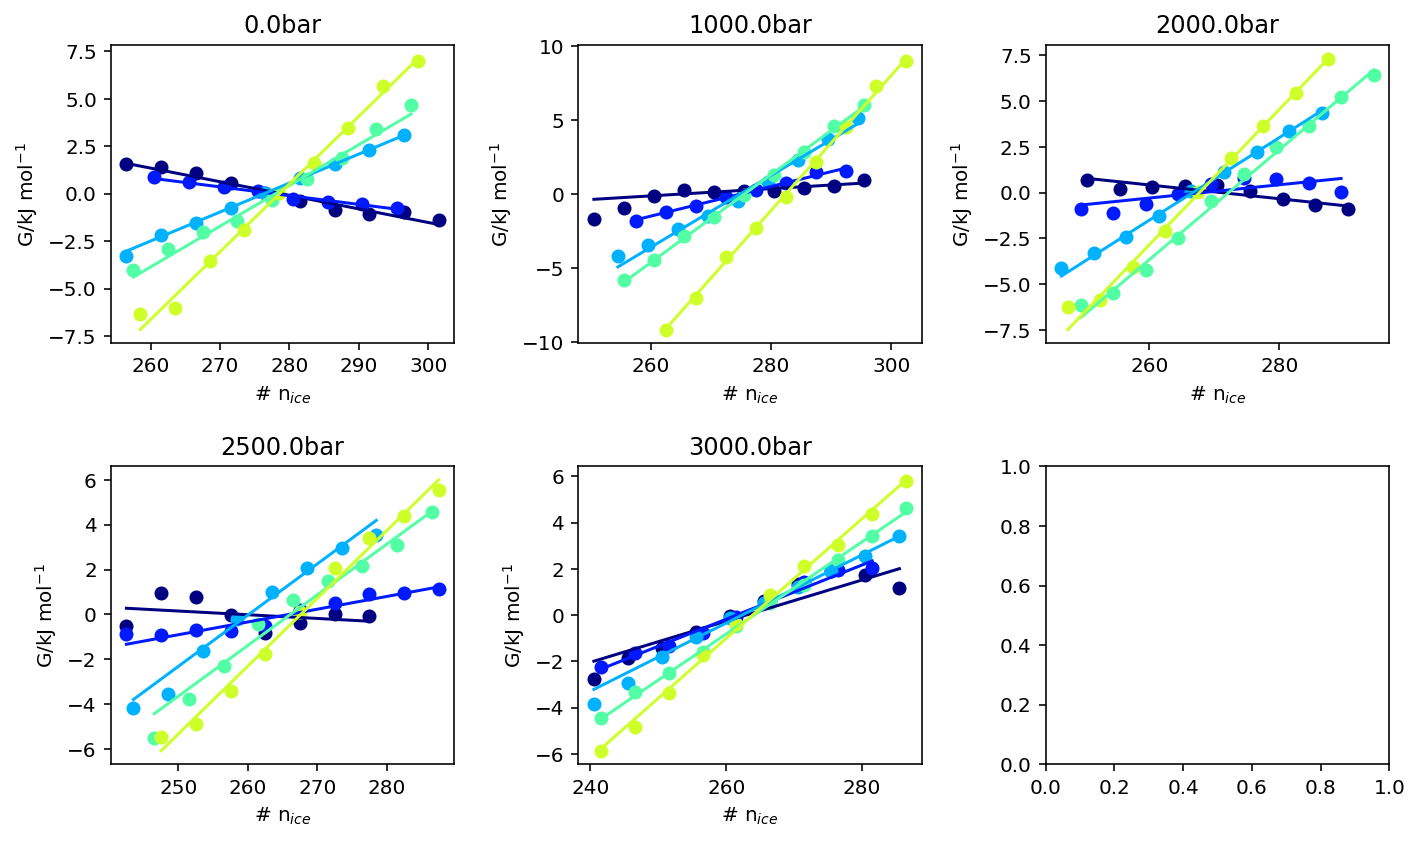

In [40]:
fig, axs = plt.subplots(2, int(np.ceil(n_pressures/2)),figsize=(10,6))
axs=axs.flatten()
press=np.unique([k.split('/')[0] for k in sims_result.keys()])
for i, p in enumerate(press):
    j=0
    for key in sims_result.keys():
        if p in key:
            axs[i].title.set_text(p.strip('COEX_'))
            sim=sims_result[key]
            axs[i].scatter(sim['n_water'],sim['fes'],color=colors[j])
            axs[i].plot(sim['n_water'],sim['fes_linear'],color=colors[j])
            j+=1
    axs[i].set_xlabel(r'# n$_{ice}$')
    axs[i].set_ylabel(r'G/kJ mol$^{-1}$')

plt.tight_layout()

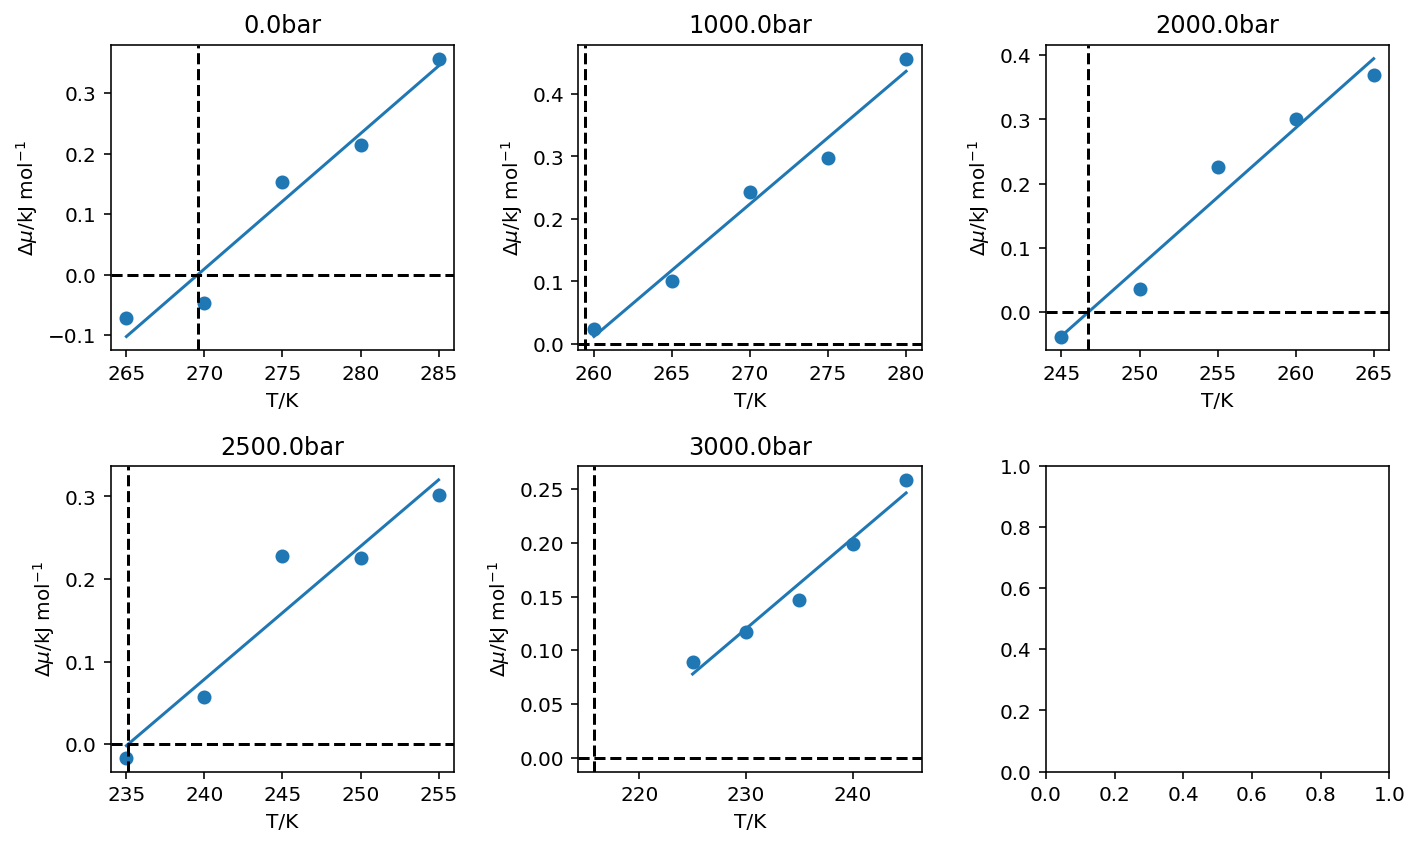

In [41]:
fig, axs = plt.subplots(2, int(np.ceil(n_pressures/2)),figsize=(10,6))
axs=axs.flatten()
coex_line=[]
for i, p in enumerate(press):
    j=0
    chem_pot=[]
    for key in sims_result.keys():
        if p in key:
            
            sim=sims_result[key]
            chem_pot.append([sims[key]['T'], sim['chem_pot'][0],sim['chem_pot'][1]])
    chem_pot = np.array(chem_pot)
    popt, pcov = curve_fit(linear_fn, chem_pot[:,0], chem_pot[:,1])#,sigma=chem_pot[:,2])

    axs[i].scatter(chem_pot[:,0],chem_pot[:,1])
    axs[i].plot(chem_pot[:,0],linear_fn(chem_pot[:,0],*popt))

    T_melt=-popt[1]/popt[0]
    coex_line.append([float(p.strip('COEX_bar')),T_melt])
    axs[i].title.set_text(p.strip('COEX_'))
    axs[i].axhline(y=0.0, linestyle='--',color='k')
    axs[i].axvline(x=T_melt, linestyle='--',color='k')
    axs[i].set_ylabel(r'$\Delta\mu$/kJ mol$^{-1}$')
    axs[i].set_xlabel('T/K')
    
coex_line=np.array(coex_line)
coex_line=coex_line[np.argsort(coex_line[:,0])]
#axs[i+1].axis('off')
plt.tight_layout()

### Store melting data

In [47]:
with open('P_T.dat','w') as fp:
    fp.write('#{:14}{:15}'.format('pressure/bar','T/K'))
    for c in coex_line:
        fp.write('\n{:<15.0f}{:<15.1f}'.format(c[0],c[1]))
!cat P_T.dat

#pressure/bar  T/K            
0              269.6          
1000           259.4          
2000           246.7          
2500           235.1          
3000           215.8          

### Plot phase diagram

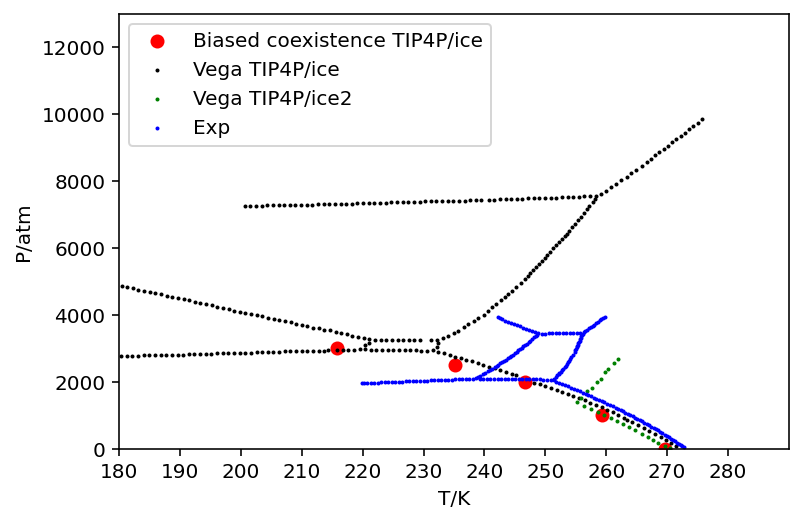

In [49]:
#exp_data=np.genfromtxt('exp_iceIh_liquid.csv')
tip4p_vega_data=np.genfromtxt('tip4p_ice_pd.dat')
tip4p_vega_data2=np.genfromtxt('tip4p_ice_pd2.dat')
tip4p_vega_data2[:,1]*=1000*0.986923

exp_data=np.genfromtxt('exp_pd.dat')
exp_data[:,1]*=10*0.986923
P_T=np.loadtxt('P_T.dat')
# Convert from MPa to bar
#exp_data[:,1]=exp_data[:,1]*10*0.986923
#exp_data=exp_data[np.argsort(exp_data[:,1])]
tip4p_vega_data[:,1]=tip4p_vega_data[:,1]*10*0.986923

plt.scatter(P_T[:,1],P_T[:,0],color='r',label='Biased coexistence TIP4P/ice')
spl = UnivariateSpline(P_T[:,0], P_T[:,1])
t_range=np.linspace(210,270,200)
p_range=np.linspace(1750,7500,200)
#plt.plot(spl(p_range),p_range)
#plt.plot(t_range,melting_line_splines(t_range),color='r')
plt.scatter(tip4p_vega_data[:,0],tip4p_vega_data[:,1],label='Vega TIP4P/ice',s=1,color='k')
plt.scatter(tip4p_vega_data2[:,0],tip4p_vega_data2[:,1],label='Vega TIP4P/ice2',s=1,color='g')

plt.scatter(exp_data[:,0],exp_data[:,1],label='Exp',s=1,color='b')

#plt.plot(exp_data[:,0],exp_data[:,1],label='Experimental')
plt.xlabel('T/K')
plt.ylabel('P/atm')
plt.legend()
plt.xlim([180,290])
plt.ylim([0,13000])
a=plt.xticks(np.arange(180,290,10))     

## Supplementary analysis

### Plot time evolution of free energy profile

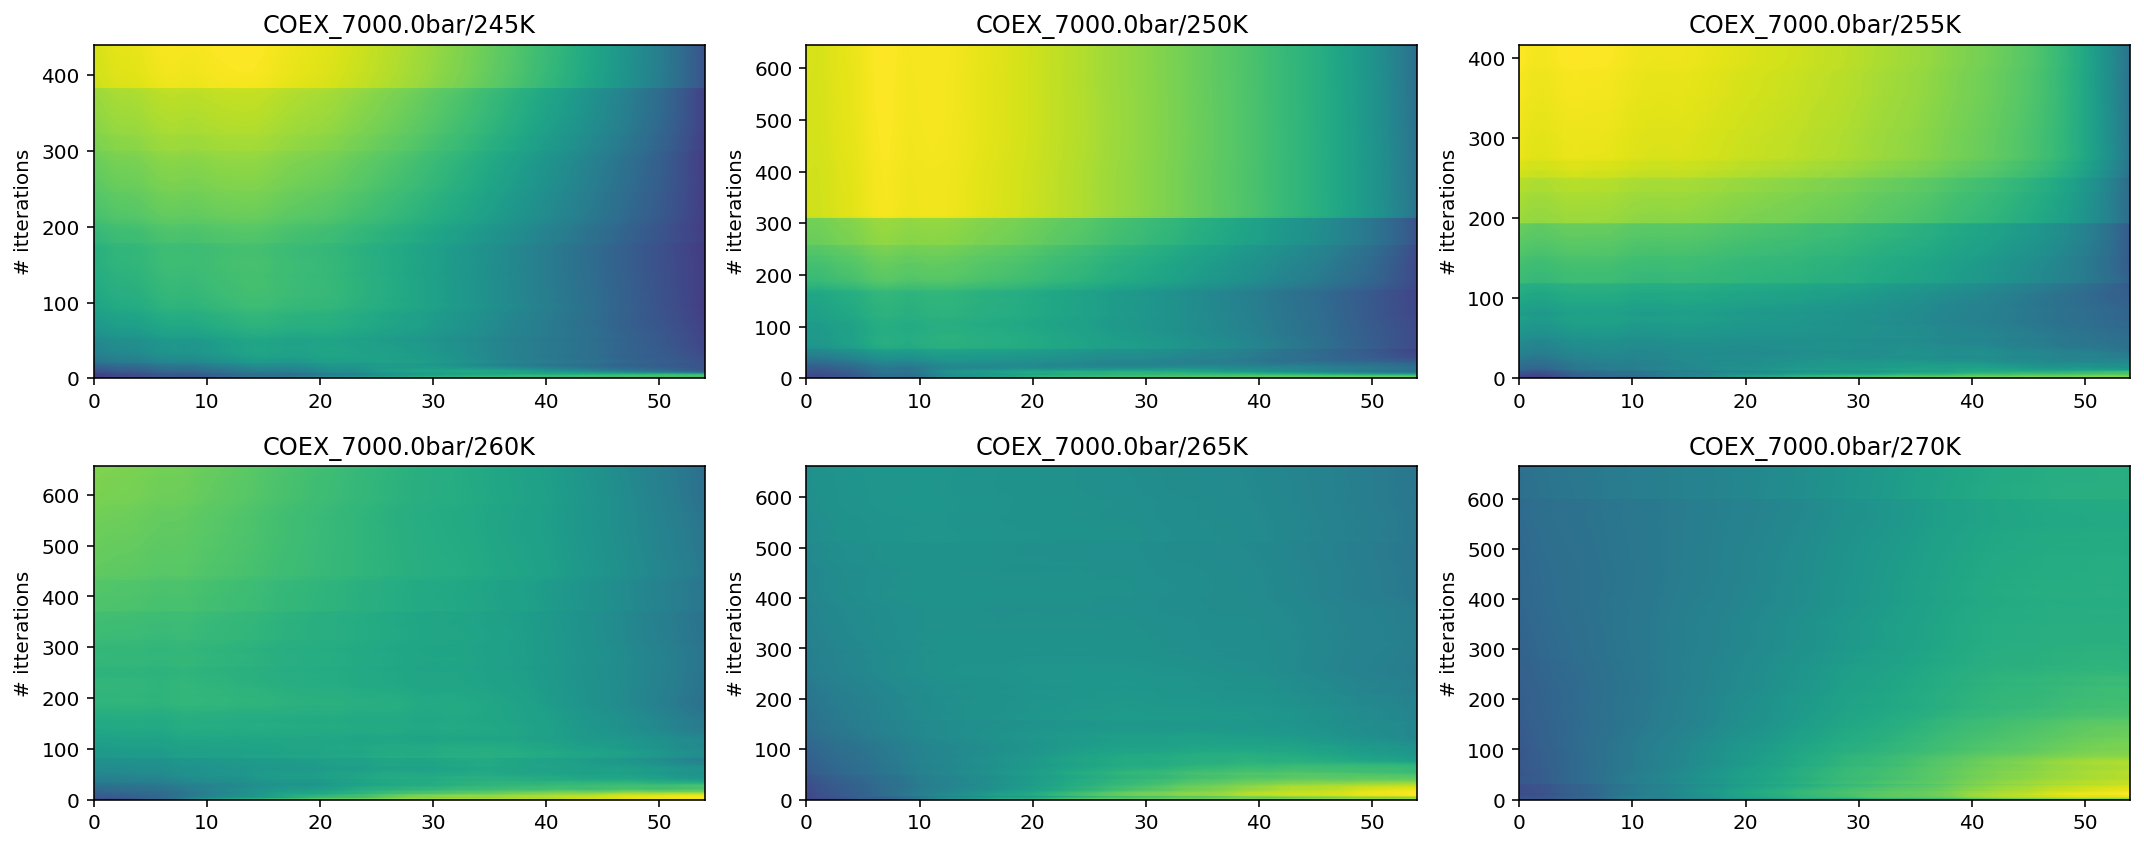

In [271]:
np.arange(240,288,1)
colors = plt.cm.jet(np.linspace(0,0.6,6))
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')

axs = axs.ravel()

j=0
for i, key in enumerate(sorted(sims.keys())):  
    if single_pressure in key:
        sim=sims[key]
        title=key.replace('COEX_'+single_pressure,'').strip('/')
        axs[j].title.set_text(key.replace('COEX_1.0bar','').strip('/'))
        axs[j].contourf((sim['DELTAFS'][:,2:]),levels=1000)#,label=title)
        axs[j].set_ylabel('# itterations')
        j+=1
plt.tight_layout()

## Visualize simulation box

In [184]:
import nglview, MDAnalysis
import MDAnalysis.transformations


In [20]:
sim_fold='COEX_'+single_pressure+'/'+single_temp+'/
u = MDAnalysis.Universe(sim_fold+'/water.data',sim_fold+'dump.dcd.0',format='dcd',in_memory=True)
typ={'2':'O', '1':'H'}

u.atoms.types=[typ[t] for t in u.atoms.types]
u.add_TopologyAttr('names')
u.atoms.names=u.atoms.types

SyntaxError: EOL while scanning string literal (1626573552.py, line 1)

In [ ]:
transform = MDAnalysis.transformations.unwrap(u.atoms)
u.trajectory.add_transformations(transform)

In [ ]:
with MDAnalysis.Writer("water_unwrapped.xtc", u.atoms) as W:
    for ts in u.trajectory:
        W.write(u.atoms)

In [ ]:
with MDAnalysis.Writer("water_unwrapped.pdb") as pdb:
    pdb.write(u.atoms)

In [ ]:
#ag = u.atoms
#transform = MDAnalysis.transformations.unwrap(ag)
#u.trajectory.add_transformations(transform)

In [ ]:

#u.atoms.types


In [ ]:
#u.atoms[0]

In [ ]:

view = nglview.show_mdanalysis(u)
view.camera = 'orthographic'
#view.add_unitcell()
#view.control.orient([1,1,1])
view.add_representation(repr_type='cartoon')#, selection=[i for i in range(100)], color='red')
#view.color_by('type')
#print(view.showow_mdanalysis)
#view.add_representation('ball')
#view.add_representation('fcsd', selection=[i for i in range(100)], color='red')
#view.add_ball
view.control.rotate(
    MDAnalysis.lib.transformations.quaternion_from_euler(
        0,   np.pi/2, 0, 'ryzy').tolist())
view.control.zoom(0.6)

#view.color_by('type')
view
#view.color_by('atomindex')


In [ ]:
view.render_image(frame=None, factor=4, antialias=True, trim=True, transparent=True)

### Plot time evolution of collective variables

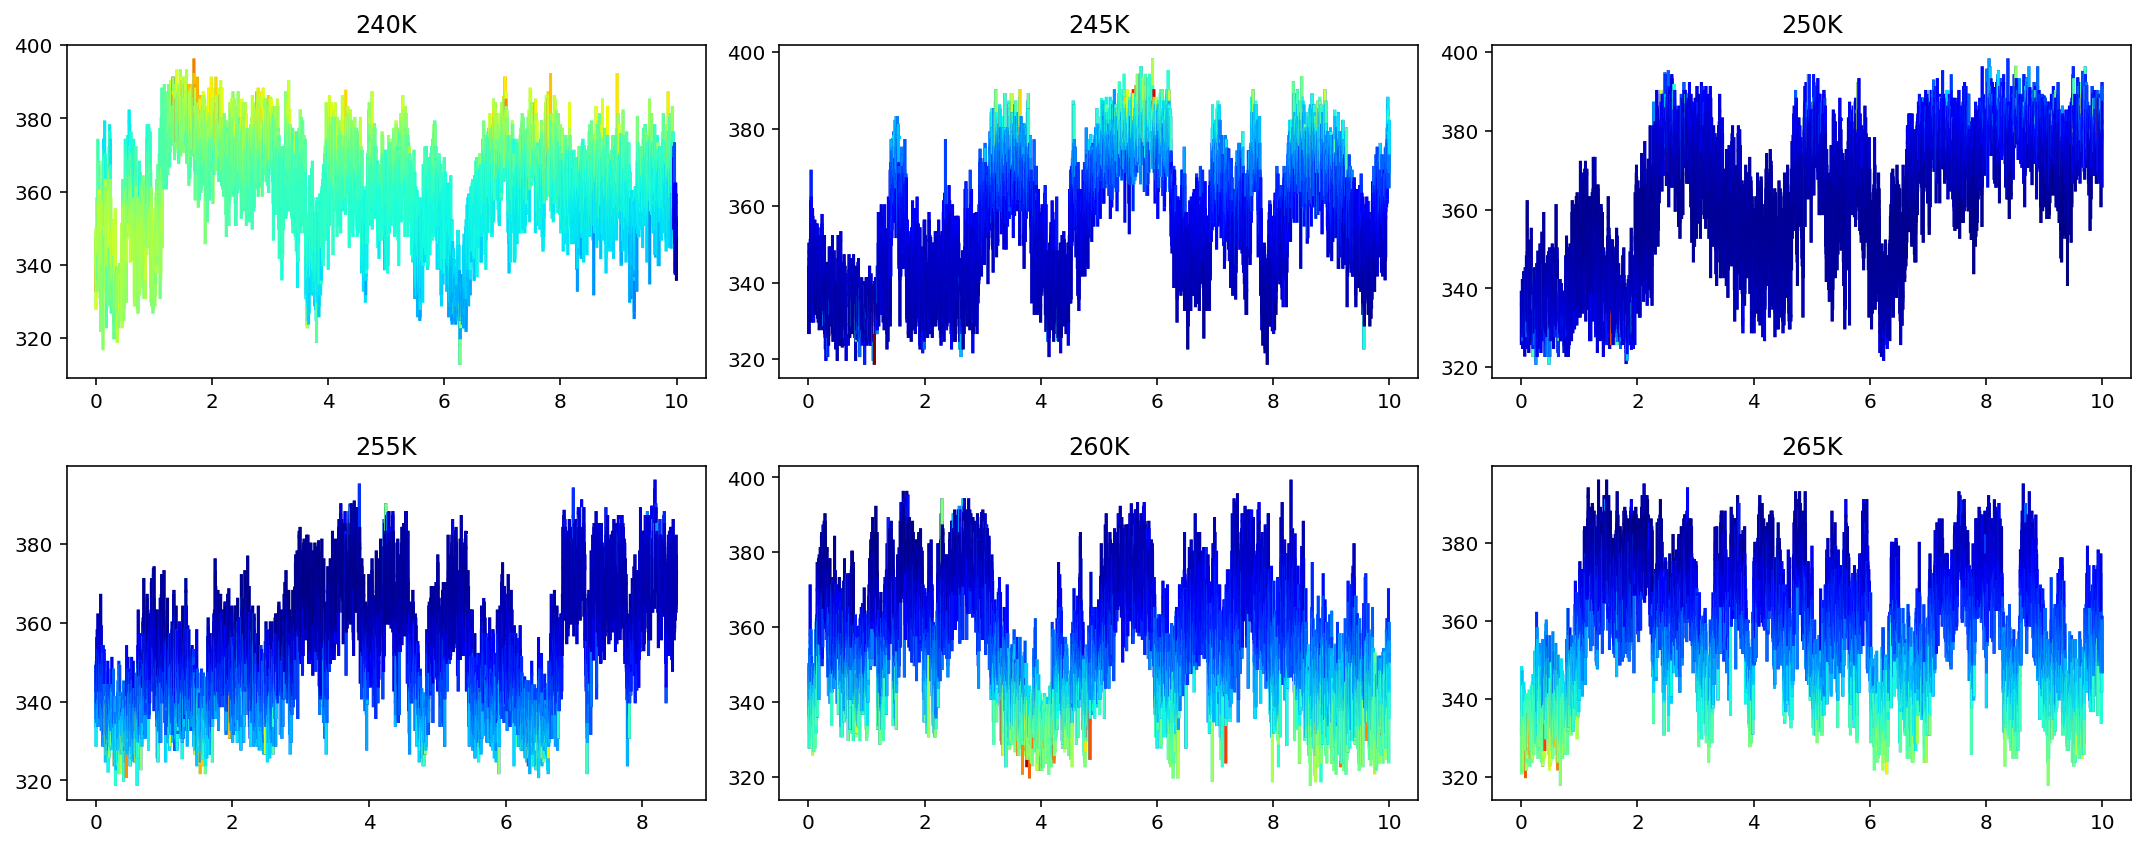

In [6]:
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')
def plot_colourline(ax,x,y,c):
    c = cm.jet((c-np.min(c))/(np.max(c)-np.min(c)))
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
    return

axs = axs.ravel()
j=0
for i, key in enumerate(sorted(sims.keys())):  
    if single_pressure in key:
        sim=sims[key]
        time0=0
        for i in range(1):
            colvar=sim['COLVAR'][i]
            bias_potential = colvar['opes.bias']
            bias_potential -= bias_potential.min()
            bias_potential=bias_potential/bias_potential[10:].max()
            cmap=plt.get_cmap('Spectral')
            norm=plt.Normalize(0.0, 1.0)
            
            plot_colourline(axs[j],time0+colvar['time_ns'], colvar['refcv2.morethan'],bias_potential)
            time0+=colvar['time_ns'][-1]
        axs[j].title.set_text(key.replace('COEX_'+single_pressure,'').strip('/'))
        j+=1
        
plt.tight_layout()

### Plot of final free energy profile

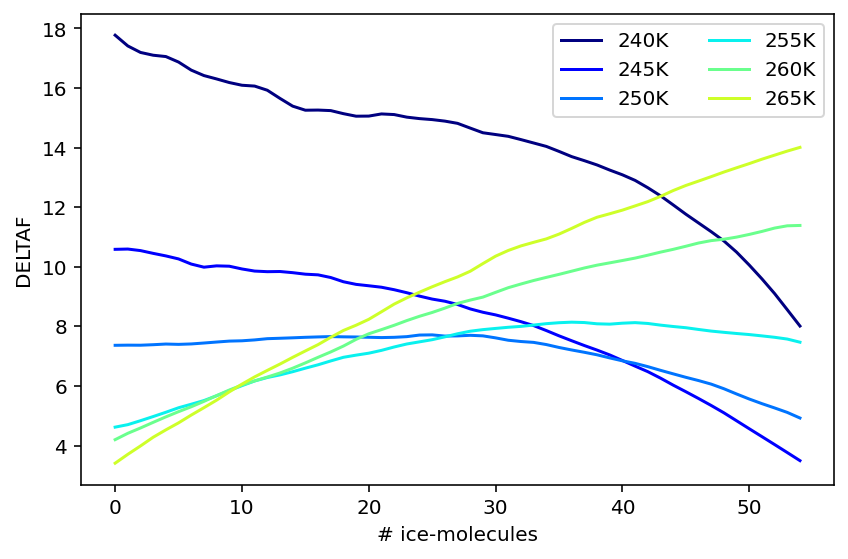

In [47]:
colors = plt.cm.jet(np.linspace(0,0.6,6))
j=0
for i, key in enumerate(sorted(sims.keys())):  
    if single_pressure in key:
        sim=sims[key]
        title=key.replace('COEX_'+single_pressure,'').strip('/')
        plt.plot(sim['DELTAFS'][-1,2:],color=colors[j],label=title)
        j+=1
plt.xlabel('# ice-molecules')
plt.ylabel('DELTAF')
plt.legend(ncol=2)       
plt.tight_layout()